In [101]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from torch.utils.data import DataLoader
import tools.dataloader as dl
import tools.metrics as met
import matplotlib.pyplot as plt
import model.architecture as arc
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision.transforms.functional as TF
import numpy as np
from PIL import Image

In [2]:
val_ds = dl.DatasetFloe_Ice_Mask(384, 'validation')
val_loader =  DataLoader(val_ds, batch_size=1, num_workers=0)

In [3]:
resnet = models.resnet34(pretrained=True)
layers = list(resnet.children())
#model = arc.ResUNet(layers, 1)

In [4]:
file = torch.load('../model/weights/384_SD.mdl')

In [5]:
model.load_state_dict(file)

<All keys matched successfully>

Patch size: 96
IoU: 0.5504258613061493
Accuracy: 0.9499090048707562


Patch size: 192
IoU: 0.5488721754957738
Accuracy: 0.959867418077257


Patch size: 288
IoU: 0.5488721754957738
Accuracy: 0.959867418077257


Patch size: 384
IoU: 0.5488721754957738
Accuracy: 0.959867418077257




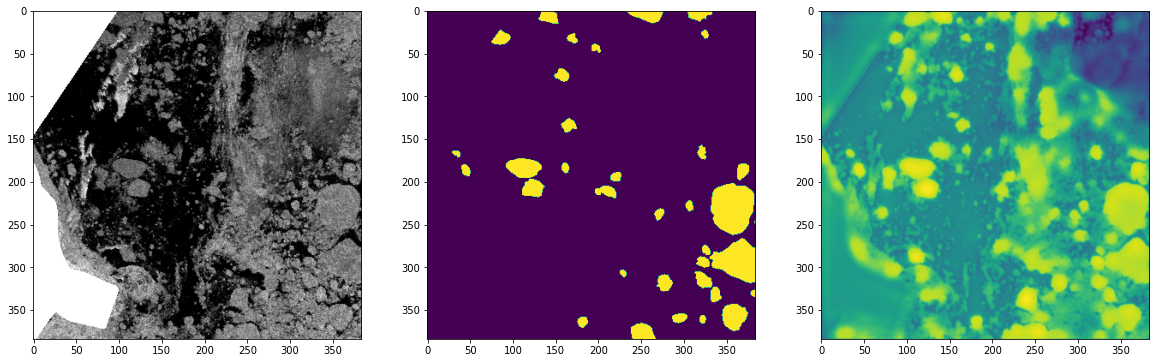

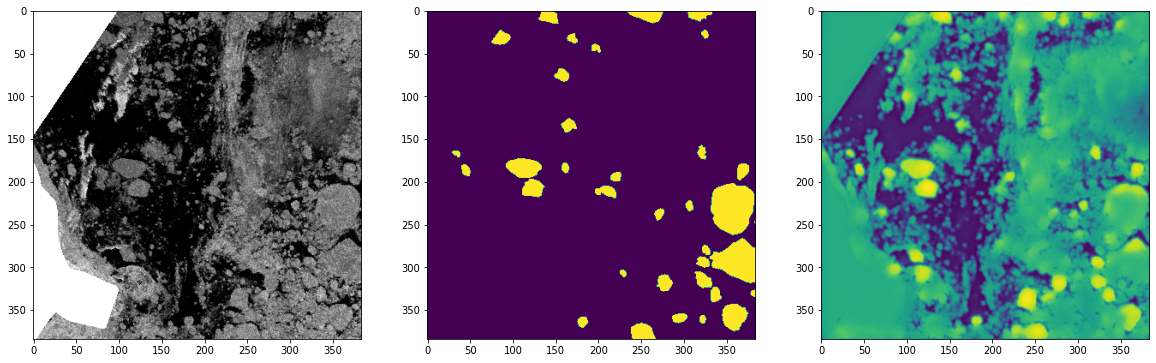

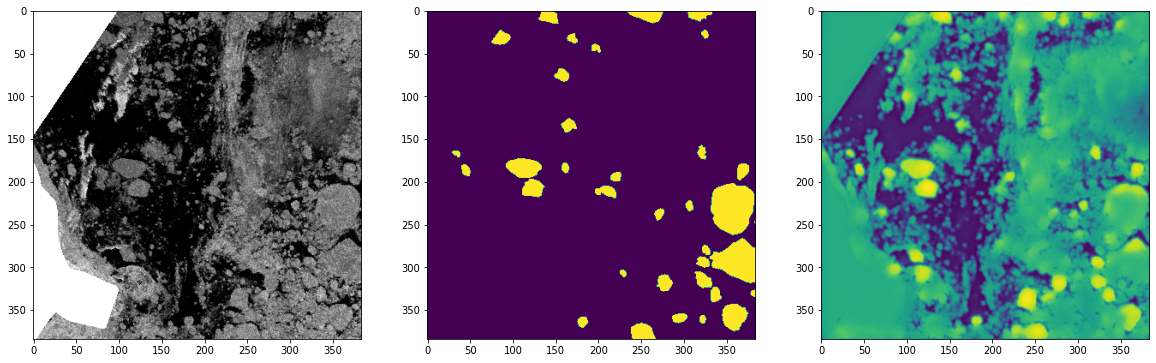

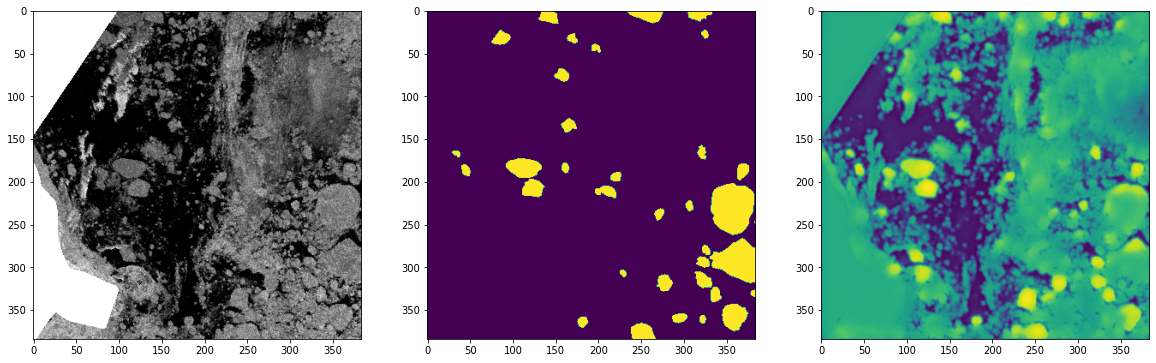

In [9]:
for size in [96, 192, 288, 384]:
    model = arc.ResUNet(layers, 1)
    file = torch.load('../model/weights/'+ str(size) + '_SD.mdl')
    #print(file)
    model.load_state_dict(file)
    model.eval()
    model.cuda()
    path_images = '../data/valid_premade_patches_multi/image_patches/'
    path_masks = '../data/valid_premade_patches_multi/mask_patches/'
    img_names = os.listdir(path_images)
    msk_names = os.listdir(path_masks)
    mIoUs, mAccs = [], []

    for batch_idx in range(len(img_names)):
        X = mpimg.imread(path_images + img_names[batch_idx])
        X = -(X * 255) + 255
        X = X[:, :, :3]
        X = TF.to_tensor(X).unsqueeze(0).cuda()
        #print(X.shape)
        y = Image.open(path_masks + msk_names[batch_idx])
        y = np.array(y)
        pred = (model(X)[0, 0, :, :].cpu().detach().numpy() > 0)
        if batch_idx == 4:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,20))
            ax1.imshow(X[0, 0, :, :].cpu().detach().numpy(), cmap='gray')
            ax2.imshow(y)
            preds = ax3.imshow(model(X)[0, 0, :, :].cpu().detach().numpy())
        mIoUs.append(met.mIoU(y, pred))
        mAccs.append(met.mAcc(y, pred))
        #plt.colorbar(preds,fraction=0.046, pad=0.04)
        #preds.set_clim(-6,6)
    
    print("Patch size: {}".format(size))
    print("IoU: {}".format(np.mean(mIoUs)))
    print("Accuracy: {}".format(np.mean(mAccs)))
    print("\n")

# 

## MOVE THIS TO TESING_STUFF. USING COZ KERNEL IS BUSY IN COMPUTATIONS

HOW TO SELECT THE PATCH SIZE 

In [102]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
import torch.nn.functional as F

from torchvision import transforms, utils, models
import torchvision.transforms.functional as TF

import numpy as np
import matplotlib.pyplot as plt
import os
import random
import cv2

In [127]:
dNet = models.densenet.densenet121(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/muzik999/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:04<00:00, 7.93MB/s]


In [128]:
layers = list(dNet.children())

In [135]:
layers0 = list(layers[0].children())

In [174]:
summary(nn.Sequential(*layers[0]), input_size = (3,224,224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]           8,192
       BatchNorm2d-8          [-1, 128, 56, 56]             256
              ReLU-9          [-1, 128, 56, 56]               0
           Conv2d-10           [-1, 32, 56, 56]          36,864
      BatchNorm2d-11           [-1, 96, 56, 56]             192
             ReLU-12           [-1, 96, 56, 56]               0
           Conv2d-13          [-1, 128, 56, 56]          12,288
      BatchNorm2d-14          [-1, 128,

In [160]:
summary(nn.Sequential(*layers0[:3]), input_size = (3,224,224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
Total params: 9,536
Trainable params: 9,536
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 18.38
Params size (MB): 0.04
Estimated Total Size (MB): 18.99
----------------------------------------------------------------


In [175]:
summary(nn.Sequential(*layers0[3:6]), input_size = (64,112,112), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         MaxPool2d-1           [-1, 64, 56, 56]               0
       BatchNorm2d-2           [-1, 64, 56, 56]             128
              ReLU-3           [-1, 64, 56, 56]               0
            Conv2d-4          [-1, 128, 56, 56]           8,192
       BatchNorm2d-5          [-1, 128, 56, 56]             256
              ReLU-6          [-1, 128, 56, 56]               0
            Conv2d-7           [-1, 32, 56, 56]          36,864
       BatchNorm2d-8           [-1, 96, 56, 56]             192
              ReLU-9           [-1, 96, 56, 56]               0
           Conv2d-10          [-1, 128, 56, 56]          12,288
      BatchNorm2d-11          [-1, 128, 56, 56]             256
             ReLU-12          [-1, 128, 56, 56]               0
           Conv2d-13           [-1, 32, 56, 56]          36,864
      BatchNorm2d-14          [-1, 128,

In [177]:
summary(nn.Sequential(*layers0[6:8]), input_size = (128,28,28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 128, 28, 28]             256
              ReLU-2          [-1, 128, 28, 28]               0
            Conv2d-3          [-1, 128, 28, 28]          16,384
       BatchNorm2d-4          [-1, 128, 28, 28]             256
              ReLU-5          [-1, 128, 28, 28]               0
            Conv2d-6           [-1, 32, 28, 28]          36,864
       BatchNorm2d-7          [-1, 160, 28, 28]             320
              ReLU-8          [-1, 160, 28, 28]               0
            Conv2d-9          [-1, 128, 28, 28]          20,480
      BatchNorm2d-10          [-1, 128, 28, 28]             256
             ReLU-11          [-1, 128, 28, 28]               0
           Conv2d-12           [-1, 32, 28, 28]          36,864
      BatchNorm2d-13          [-1, 192, 28, 28]             384
             ReLU-14          [-1, 192,

In [45]:
"""
DATA LOADER FOR UNET, SINGLE OUT CHANNEl
"""

class DatasetFloe(Dataset):
    def __init__(self, patch_size, mode):
        self.path_images = '../data/images/' + mode
        self.path_masks = '../data/annotation_masks/'
#         self.path_ice_conc = '../data/ice_conc/'
        self.patchsize = patch_size
        self.img_names = os.listdir(self.path_images)
        
    def transform(self, img, mask):
        
        image = TF.to_pil_image(img)
        mask = TF.to_pil_image(mask)
#         ice = TF.to_pil_image(ice.astype(np.float32)/100)
        
        # Random horizontal flip
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask= TF.hflip(mask)
#             ice = TF.hflip(ice)
            
        # Random Vertical flip
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
#             ice = TF.vflip(ice)
            
        # To Tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask).float()
#         ice = TF.to_tensor(ice)
        
        # Stack image and ice so that network accepts them as two channels.
#         image = torch.stack((image.squeeze(), image.squeeze(), image.squeeze()), dim = 0)
        
        return image, mask
            
        
    def __len__(self):
        return 32 # We are generating images on the go.
    
    def __getitem__(self, index):
        file_name = random.choice(self.img_names)[:-4]

        img = plt.imread(os.path.join(self.path_images,file_name + '.tif'))
        mask = cv2.imread(os.path.join(self.path_masks,file_name + '.png'))
#         ice_conc = np.load(os.path.join(self.path_ice_conc,file_name + '.npy'))
        
        mask = (mask[:,:,2] / 128).astype(np.int32)
        
        img_x, img_y = img.shape
        
        patch_x = int((img_x - self.patchsize) * random.random())
        patch_y = int((img_y - self.patchsize) * random.random())
        
        img_patch = img[patch_x: (patch_x+self.patchsize) ,patch_y:(patch_y+self.patchsize)]
        mask_patch = mask[patch_x: (patch_x+self.patchsize) ,patch_y:(patch_y+self.patchsize)]
#         ice_conc_patch = ice_conc[patch_x: (patch_x+self.patchsize) ,patch_y:(patch_y+self.patchsize)]
        
        img_patch, mask_patch = self.transform(img_patch, mask_patch)
        
        sample = {'image': img_patch, 'mask': mask_patch}
        
        return sample

In [46]:
train_ds = DatasetFloe(int(200), 'train')


In [73]:
idx, sample = next(enumerate(train_ds))

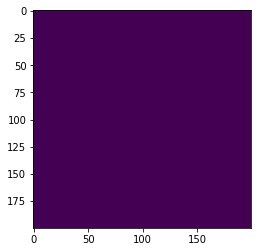

In [74]:
plt.imshow(sample['mask'].squeeze())

In [6]:
img_pth = '/home/muzik999/MASc/iceFloe/floes/data/images/train/im_rsat2_ar_20130603112554_00104877_l.tif'
msk_pth = '/home/muzik999/MASc/iceFloe/floes/data/annotation_masks/im_rsat2_ar_20130603112554_00104877_l.png'

In [15]:
img = plt.imread(img_pth)
mask = plt.imread(msk_pth)

In [13]:
# mask = (mask[:,:,2] / 128).astype(np.int32)

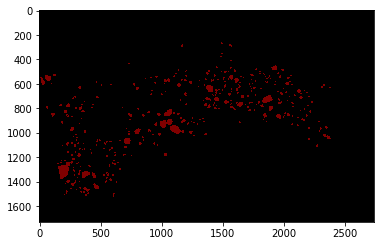

In [16]:
plt.imshow(mask)

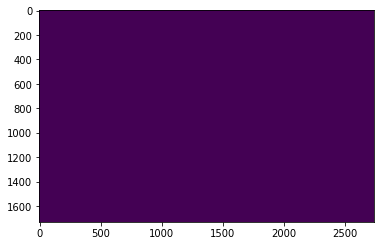

In [20]:
plt.imshow(mask[:,:,1])

In [88]:
im = cv2.imread("/home/muzik999/MASc/iceFloe/floes/data/annotation_masks/im_rsat2_ar_20081113112900_00042229_l.png", cv2.IMREAD_GRAYSCALE)

In [89]:
is_v2 = cv2.__version__.startswith("2.")
if is_v2:
    detector = cv2.SimpleBlobDetector()
else:
    detector = cv2.SimpleBlobDetector_create()

In [99]:
im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

NameError: name 'thresh' is not defined

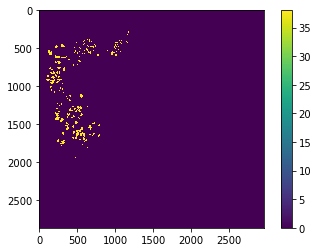

In [100]:
plt.imshow(im)
plt.colorbar()